Install module

In [ ]:
!pip install transformers tensorflow torch numpy pandas scikit-learn matplotlib tensorflow_hub rouge-score sacrebleu

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 4.2 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=c7e87442d7221b624fcdbcea59e9832af8c5b61499eddb00343f60188755544f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


Import modules

In [ ]:
import pandas as pd
import numpy as np
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from transformers import T5ForConditionalGeneration, T5Tokenizer, AdamW
import torch
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
import sacrebleu
from google.colab import files

Load dataset

In [ ]:
print("Upload your JSON dataset: ")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]

df = pd.read_json(file_name)

print(df.head())

df.dropna(inplace=True)

print("\nDataFrame Info:")
print(df.info())

print("\nDataFrame Shape:", df.shape)

print("\nCount of question-answer pair: ",df['pertanyaan'].count())

Upload your JSON dataset: 


Saving datachatbot1.json to datachatbot1 (1).json
                 pertanyaan                                            jawaban
0           Halo, Walet AI!  Halo! Selamat datang di dunia burung walet! Ad...
1  Hai, apa kabar Walet AI?  Hai! Saya baik, terima kasih. Ada yang ingin A...
2   Hallo, bisa bantu saya?  Hallo! Tentu saja, saya siap membantu pertanya...
3          Hello, Walet AI!  Hello! Selamat datang, ada yang bisa saya bant...
4   Hi, apa kabar Walet AI?  Hi! Saya baik-baik saja. Bagaimana dengan Anda...

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379 entries, 0 to 1378
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pertanyaan  1379 non-null   object
 1   jawaban     1379 non-null   object
dtypes: object(2)
memory usage: 21.7+ KB
None

DataFrame Shape: (1379, 2)

Count of question-answer pair:  1379


Split dataset

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

Load USE (Universal Sentence Encoder) from TensorFlow Hub

In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
encoded_train_questions = embed(train_df['pertanyaan'].tolist())
encoded_test_questions = embed(test_df['pertanyaan'].tolist())

Load T5 (Text-to-Text Transfer Transformer) Model

In [ ]:
model_name = "t5-small" # or base
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

Train the model with tuned parameters

In [ ]:
# Model training

learning_rate=5e-4

optimizer = AdamW(model.parameters(), lr=learning_rate) # learning rate
model.train()

def train_model(train_df, epochs=20):
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for _, row in train_df.iterrows():
            input_text = f"pertanyaan: {row['pertanyaan']} </s>"
            target_text = f"{row['jawaban']} </s>"

            input_ids = tokenizer.encode(input_text, return_tensors="pt")
            target_ids = tokenizer.encode(target_text, return_tensors="pt")

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, labels=target_ids)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_df)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} done, Loss average: {avg_loss:.4f}")

    return losses

# Train the model
losses = train_model(train_df)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


Epoch 1/20 done, Loss average: 2.2566
Epoch 2/20 done, Loss average: 1.4525
Epoch 3/20 done, Loss average: 1.1541
Epoch 4/20 done, Loss average: 0.9654
Epoch 5/20 done, Loss average: 0.8315
Epoch 6/20 done, Loss average: 0.7262
Epoch 7/20 done, Loss average: 0.6475
Epoch 8/20 done, Loss average: 0.5789
Epoch 9/20 done, Loss average: 0.5188
Epoch 10/20 done, Loss average: 0.4690
Epoch 11/20 done, Loss average: 0.4301
Epoch 12/20 done, Loss average: 0.3879
Epoch 13/20 done, Loss average: 0.3617
Epoch 14/20 done, Loss average: 0.3244
Epoch 15/20 done, Loss average: 0.3025
Epoch 16/20 done, Loss average: 0.2785
Epoch 17/20 done, Loss average: 0.2644
Epoch 18/20 done, Loss average: 0.2457
Epoch 19/20 done, Loss average: 0.2221
Epoch 20/20 done, Loss average: 0.2106


Loss visualization

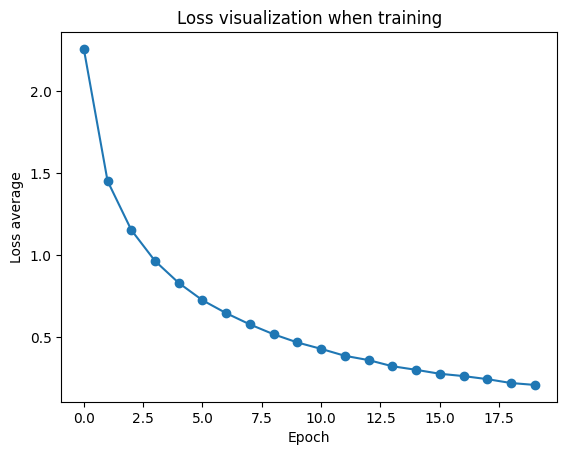

In [ ]:
plt.plot(losses, marker='o')
plt.title('Loss visualization when training')
plt.xlabel('Epoch')
plt.ylabel('Loss average')
plt.show()

Model Evaluation and prediction test

In [ ]:
model.eval()
predictions = []

for _, row in test_df.iterrows():
    input_text = f"pertanyaan: {row['pertanyaan']} </s>"
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    outputs = model.generate(input_ids, max_length=50)
    generated_answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    predictions.append(generated_answer)

ROUGE evaluation metrics

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = []

for true, pred in zip(test_df['jawaban'], predictions):
    score = scorer.score(true, pred)
    rouge_scores.append(score)

# Menampilkan rata-rata skor ROUGE
avg_rouge1 = np.mean([score['rouge1'].fmeasure for score in rouge_scores])
avg_rouge2 = np.mean([score['rouge2'].fmeasure for score in rouge_scores])
avg_rougeL = np.mean([score['rougeL'].fmeasure for score in rouge_scores])

print(f"ROUGE-1: {avg_rouge1:.4f}")
print(f"ROUGE-2: {avg_rouge2:.4f}")
print(f"ROUGE-L: {avg_rougeL:.4f}")

ROUGE-1: 0.4773
ROUGE-2: 0.2859
ROUGE-L: 0.4256


BLEU evaluation metrics

In [ ]:
bleu_score = sacrebleu.corpus_bleu(predictions, [test_df['jawaban'].tolist()])
print(f"BLEU Score: {bleu_score.score:.4f}")

BLEU Score: 18.5550


Result summary

In [ ]:
print("\nResult Summary v0.3.2")
print(f"ROUGE-1: {avg_rouge1:.4f}")
print(f"ROUGE-2: {avg_rouge2:.4f}")
print(f"ROUGE-L: {avg_rougeL:.4f}")
print(f"BLEU Score: {bleu_score.score:.4f}")

print("\nTraining Losses Summary")
print("Loss per epoch:")
for i, loss in enumerate(losses):
    print(f"Epoch {i + 1}: {loss:.4f}")

average_loss = sum(losses) / len(losses)
print(f"\nAverage Training Loss: {average_loss:.4f}")

print("\nLearning Rate: ",learning_rate)
print("\nCount of question-answer pair: ",df['pertanyaan'].count())

# Save to txt
output_txt_path = 'training_summary.txt'

with open(output_txt_path, 'w') as f:
    f.write("Result Summary\n")
    f.write(f"ROUGE-1: {avg_rouge1:.4f}\n")
    f.write(f"ROUGE-2: {avg_rouge2:.4f}\n")
    f.write(f"ROUGE-L: {avg_rougeL:.4f}\n")
    f.write(f"BLEU Score: {bleu_score.score:.4f}\n")

    f.write("\nTraining Losses Summary\n")
    f.write("Loss per epoch:\n")
    for i, loss in enumerate(losses):
        f.write(f"Epoch {i + 1}: {loss:.4f}\n")

    # Simpan rata-rata loss keseluruhan
    average_loss = sum(losses) / len(losses)
    f.write(f"\nAverage Training Loss: {average_loss:.4f}\n")
    f.write(f"Learning Rate: {learning_rate}\n")
    f.write(f"Count of question-answer pair: {df['pertanyaan'].count()}\n")
print(f"Training summary saved to {output_txt_path}")



Result Summary v0.3.2
ROUGE-1: 0.4773
ROUGE-2: 0.2859
ROUGE-L: 0.4256
BLEU Score: 18.5550

Training Losses Summary
Loss per epoch:
Epoch 1: 2.2566
Epoch 2: 1.4525
Epoch 3: 1.1541
Epoch 4: 0.9654
Epoch 5: 0.8315
Epoch 6: 0.7262
Epoch 7: 0.6475
Epoch 8: 0.5789
Epoch 9: 0.5188
Epoch 10: 0.4690
Epoch 11: 0.4301
Epoch 12: 0.3879
Epoch 13: 0.3617
Epoch 14: 0.3244
Epoch 15: 0.3025
Epoch 16: 0.2785
Epoch 17: 0.2644
Epoch 18: 0.2457
Epoch 19: 0.2221
Epoch 20: 0.2106

Average Training Loss: 0.6314

Learning Rate:  0.0005

Count of question-answer pair:  1379
Training summary saved to training_summary.txt


Prediction test

In [ ]:
for i in range(len(test_df)): # Changed to iterate over the actual number of rows in test_df
    print("Pertanyaan:", test_df.iloc[i]['pertanyaan'])
    print("Jawaban Asli:", test_df.iloc[i]['jawaban'])
    print("Jawaban Prediksi:", predictions[i]) # Assuming predictions has at least the same number of elements as test_df
    print()

Pertanyaan: Bagaimana cara membedakan sarang burung walet hasil budidaya dengan yang alami?
Jawaban Asli: Sarang hasil budidaya dibuat di rumah sarang buatan yang kebersihannya lebih terjaga, sedangkan yang alami lebih terpengaruh kondisi alam.
Jawaban Prediksi: Sarang burung walet hasil budidaya lebih terjaga kebersihannya dibandingkan yang alami di gua atau alam li

Pertanyaan: Mengapa burung walet lebih mudah membuat sarang di musim hujan?
Jawaban Asli: Karena kelembaban udara yang tinggi di musim hujan mempermudah proses pembuatan sarang oleh burung walet.
Jawaban Prediksi: Karena kelembaban tinggi di musim hujan memberikan kondisi yang optimal bagi burung walet untuk membangun sarang.

Pertanyaan: Apakah makanan berperan dalam warna sarang burung walet?
Jawaban Asli: Ya, makanan yang dimakan burung walet berperan besar dalam mempengaruhi warna sarang yang mereka buat.
Jawaban Prediksi: Ya, makanan berperan dalam warna sarang burung walet dipengaruhi oleh peran dalam warna sarang m

Save model

In [ ]:
from google.colab import drive
import shutil

drive.mount('/content/drive')

drive_path = '/content/drive/My Drive/trained_model_0.4.zip'

output_dir = './trained_model'
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

zip_filename = 'trained_model.zip'
shutil.make_archive('trained_model', 'zip', output_dir)

shutil.move(zip_filename, drive_path)

print(f"Model & tokenizer successfully saved and compressed as {drive_path}")


Mounted at /content/drive
Model & tokenizer successfully saved and compressed as /content/drive/My Drive/trained_model_0.4.zip


Load and use model

In [ ]:
model_path = './trained_model'
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)

def generate_response(question):
    input_text = f"question: {question} </s>"
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    outputs = model.generate(input_ids, max_length=150)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

question =   "durasi waktu burung walet membangun sarangnya?"
answer = generate_response(question)
print("Question:", question)
print("Answer:", answer)


Question: durasi waktu burung walet membangun sarangnya?
Answer: Durasi waktu burung walet membangun sarangnya adalah 2 hingga 3 bulan, dengan proses pembentukan dan pengelolaan lingkungan yang lebih baik.
